# ECG Data Visualization Example

This notebook demonstrates how to load and visualize ECG data from the SeizeIT2 dataset using the provided data classes.

In [10]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Add Information/Data/seizeit2-main to path
sys.path.append(os.path.join('..', 'Information', 'Data', 'seizeit2-main'))

from classes.data import Data
from classes.annotation import Annotation

## Define Plot Function

This function loads and plots ECG data for a specified patient.

In [11]:
def plot_patient_ecg(data_path, patient_id='sub-001', duration_minutes=5):
    """
    Lädt und plottet ECG-Daten eines Patienten mit Seizure-Markierungen
    
    Args:
        data_path (str): Pfad zum ds005873-download Ordner
        patient_id (str): Patient ID (z.B. 'sub-001')
        duration_minutes (int): Anzahl Minuten zum Plotten
    """
    
    data_path = Path(data_path)
    
    # Überprüfe ob Pfad existiert
    if not data_path.exists():
        print(f"Fehler: Pfad {data_path} existiert nicht!")
        return
    
    # Finde verfügbare Aufnahmen für den Patienten
    patient_path = data_path / patient_id / 'ses-01' / 'ecg'
    if not patient_path.exists():
        print(f"Fehler: ECG-Daten für {patient_id} nicht gefunden!")
        return
    
    # Lade erste verfügbare ECG-Aufnahme
    ecg_files = list(patient_path.glob("*.edf"))
    if not ecg_files:
        print(f"Keine ECG-Dateien für {patient_id} gefunden!")
        return
    
    # Extrahiere run-info aus Dateiname
    first_file = ecg_files[0]
    run_info = first_file.name.split('_')[-2]  # z.B. 'run-01'
    
    print(f"Lade Daten für {patient_id}, {run_info}")
    
    # Lade ECG-Daten
    recording = [patient_id, run_info]
    data = Data.loadData(data_path.as_posix(), recording, modalities=['ecg'])
    
    if not data.data:
        print("Keine ECG-Daten geladen!")
        return
    
    # Lade Annotationen
    annotations = None
    try:
        annotations = Annotation.loadAnnotation(data_path.as_posix(), recording)
        print(f"Annotationen geladen: {len(annotations.events)} Seizure-Events gefunden")
    except Exception as e:
        print(f"Warnung: Annotationen konnten nicht geladen werden: {e}")
    
    # Plot ECG-Daten
    ecg_signal = data.data[0]  # Erste ECG-Kanal
    fs = data.fs[0]  # Sampling frequency
    channel_name = data.channels[0] if data.channels else 'ECG'
    
    # Zeitachse erstellen
    total_samples = len(ecg_signal)
    time_total = total_samples / fs
    time = np.linspace(0, time_total, total_samples)
    
    # Begrenzen auf gewünschte Dauer
    max_samples = int(duration_minutes * 60 * fs)
    if max_samples < total_samples:
        ecg_signal = ecg_signal[:max_samples]
        time = time[:max_samples]
        plot_duration = duration_minutes * 60
    else:
        plot_duration = time_total
    
    # Plot erstellen
    plt.figure(figsize=(15, 8))
    plt.plot(time, ecg_signal, 'b-', linewidth=0.5, label='ECG Signal')
    
    # Seizure-Bereiche markieren
    seizure_count = 0
    if annotations and annotations.events:
        for i, (start_time, end_time) in enumerate(annotations.events):
            # Nur Seizures im sichtbaren Zeitbereich anzeigen
            if start_time < plot_duration:
                # Begrenze end_time auf sichtbaren Bereich
                visible_end = min(end_time, plot_duration)
                
                plt.axvspan(start_time, visible_end, alpha=0.3, color='red', 
                           label='Seizure' if i == 0 else "")
                
                # Füge Text-Annotation hinzu
                mid_time = (start_time + visible_end) / 2
                seizure_type = annotations.types[i] if i < len(annotations.types) else 'unknown'
                plt.text(mid_time, plt.ylim()[1] * 0.9, f'Seizure\n{seizure_type}', 
                        ha='center', va='top', fontsize=8, 
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))
                seizure_count += 1
    
    plt.xlabel('Zeit (s)')
    plt.ylabel('Amplitude')
    plt.title(f'ECG Signal mit Seizure-Markierungen - {patient_id} {run_info} - Kanal: {channel_name}')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Zeige Sampling-Info und Seizure-Info
    info_text = f'Sampling Rate: {fs} Hz\nGesamtdauer: {time_total:.1f}s\nSeizures im Plot: {seizure_count}'
    if annotations and annotations.events:
        total_seizures = len(annotations.events)
        info_text += f'\nTotal Seizures: {total_seizures}'
    
    plt.text(0.02, 0.98, info_text, 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"ECG-Daten geladen:")
    print(f"  - Kanäle: {data.channels}")
    print(f"  - Sampling Rates: {data.fs} Hz")
    print(f"  - Datenpunkte: {len(ecg_signal)}")
    print(f"  - Dauer: {time_total:.1f} Sekunden")
    
    if annotations and annotations.events:
        print(f"\nSeizure-Informationen:")
        for i, (start, end) in enumerate(annotations.events):
            seizure_type = annotations.types[i] if i < len(annotations.types) else 'unknown'
            duration = end - start
            print(f"  - Seizure {i+1}: {start:.1f}s - {end:.1f}s ({duration:.1f}s, Type: {seizure_type})")
    
    return data, annotations

## Configuration

Set the dataset path and plotting parameters.

In [12]:
# Dataset ist bereits im Projektordner verfügbar
dataset_path = "../ds005873-download"

print("ECG Plotting Script für SeizeIT2 Dataset")
print("=" * 50)
print(f"Dataset Pfad: {dataset_path}")
print()

ECG Plotting Script für SeizeIT2 Dataset
Dataset Pfad: ../ds005873-download



## Plot ECG Data

Load and visualize ECG data for a patient.

Lade Daten für sub-001, run-01
Annotationen geladen: 0 Seizure-Events gefunden


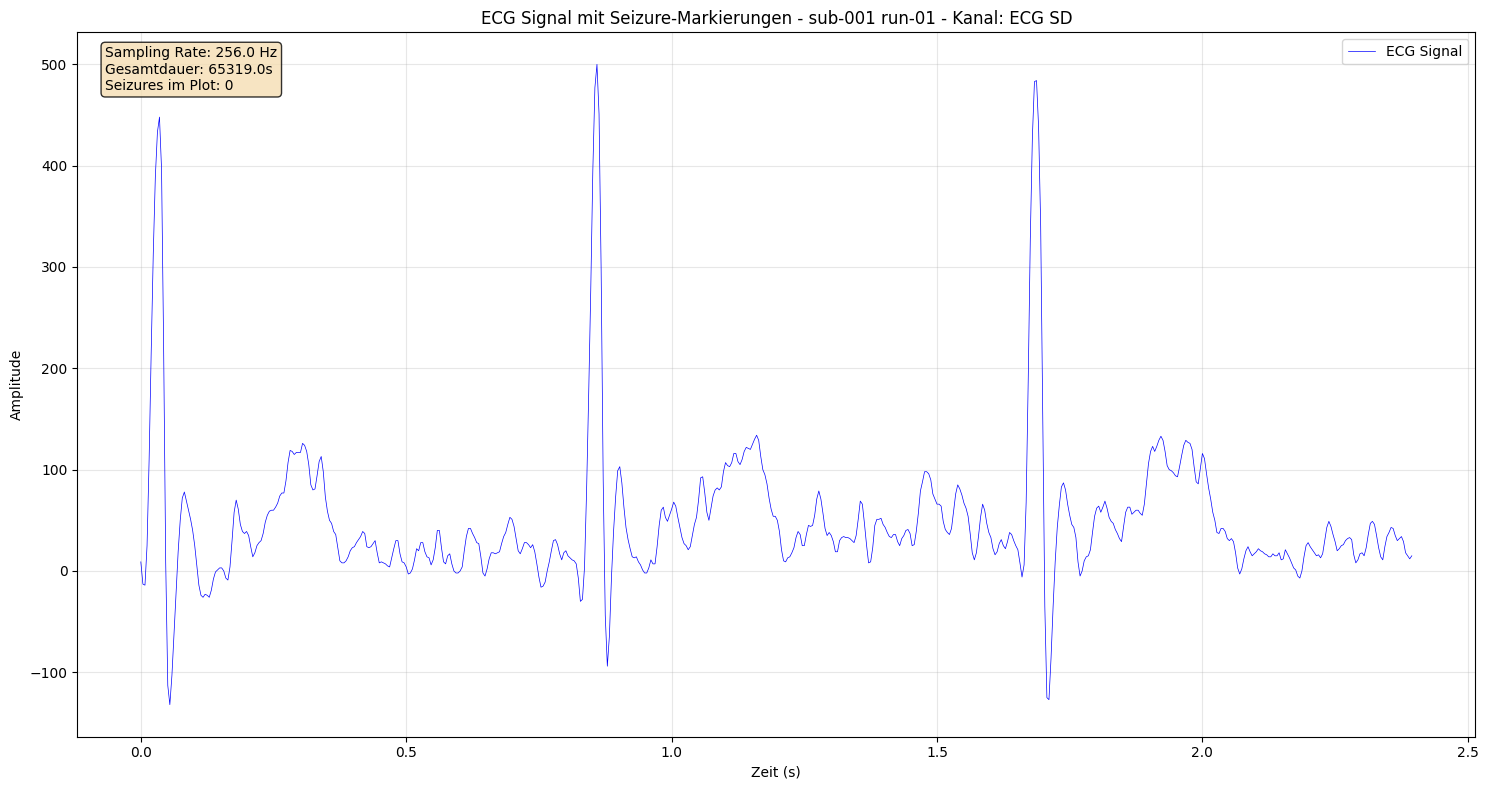

ECG-Daten geladen:
  - Kanäle: ['ECG SD']
  - Sampling Rates: [np.float64(256.0)] Hz
  - Datenpunkte: 614
  - Dauer: 65319.0 Sekunden


In [25]:
# Lade und plotte ECG für ersten Patienten
data, annotations = plot_patient_ecg(dataset_path, patient_id='sub-001', duration_minutes=0.04)

## Explore Different Patients

You can modify the patient_id and duration_minutes to explore different patients and time segments.

In [14]:
# Example: Plot different patient
# plot_patient_ecg(dataset_path, patient_id='sub-002', duration_minutes=5)

# Example: Plot longer duration
# plot_patient_ecg(dataset_path, patient_id='sub-001', duration_minutes=10)

## Function for Finding Patients with Seizures

Let's add a helper function to find patients that have seizure annotations.

In [15]:
def find_patients_with_seizures(data_path, max_patients=5):
    """
    Findet Patienten mit Seizure-Annotationen
    
    Args:
        data_path (str): Pfad zum ds005873-download Ordner
        max_patients (int): Maximale Anzahl Patienten zu überprüfen
    
    Returns:
        list: Liste von (patient_id, run_id, seizure_count) Tupeln
    """
    data_path = Path(data_path)
    patients_with_seizures = []
    
    # Finde alle Patienten-Ordner
    patient_dirs = sorted([d for d in data_path.iterdir() if d.is_dir() and d.name.startswith('sub-')])
    
    print(f"Überprüfe {min(max_patients, len(patient_dirs))} Patienten auf Seizure-Annotationen...")
    
    for i, patient_dir in enumerate(patient_dirs[:max_patients]):
        patient_id = patient_dir.name
        
        # Suche nach ECG-Dateien
        ecg_path = patient_dir / 'ses-01' / 'ecg'
        if not ecg_path.exists():
            continue
            
        ecg_files = list(ecg_path.glob("*.edf"))
        for ecg_file in ecg_files:
            # Extrahiere run-info
            run_info = ecg_file.name.split('_')[-2]
            
            try:
                # Versuche Annotationen zu laden
                recording = [patient_id, run_info]
                annotations = Annotation.loadAnnotation(data_path.as_posix(), recording)
                
                if annotations.events and len(annotations.events) > 0:
                    patients_with_seizures.append((patient_id, run_info, len(annotations.events)))
                    print(f"✓ {patient_id} {run_info}: {len(annotations.events)} Seizures")
                    
            except Exception as e:
                continue  # Keine Annotationen verfügbar
    
    return patients_with_seizures

## Find and Plot Patients with Seizures

Now let's find patients that have seizure data and plot their ECG with seizure markings.

Überprüfe 10 Patienten auf Seizure-Annotationen...
✓ sub-001 run-03: 1 Seizures
✓ sub-001 run-05: 1 Seizures
✓ sub-001 run-07: 1 Seizures
✓ sub-001 run-08: 1 Seizures
✓ sub-002 run-01: 2 Seizures
✓ sub-002 run-02: 2 Seizures
✓ sub-002 run-03: 1 Seizures
✓ sub-002 run-05: 2 Seizures
✓ sub-002 run-06: 3 Seizures
✓ sub-002 run-09: 4 Seizures
✓ sub-002 run-10: 1 Seizures
✓ sub-003 run-06: 1 Seizures
✓ sub-004 run-01: 4 Seizures
✓ sub-005 run-22: 1 Seizures
✓ sub-005 run-23: 1 Seizures
✓ sub-006 run-01: 1 Seizures
✓ sub-007 run-03: 2 Seizures
✓ sub-008 run-01: 1 Seizures
✓ sub-008 run-09: 1 Seizures
✓ sub-009 run-09: 1 Seizures
✓ sub-010 run-08: 1 Seizures

Gefunden: 21 Aufnahmen mit Seizures

Plotte sub-001 run-03 mit 1 Seizure(s):
Lade Daten für sub-001, run-01
Annotationen geladen: 0 Seizure-Events gefunden


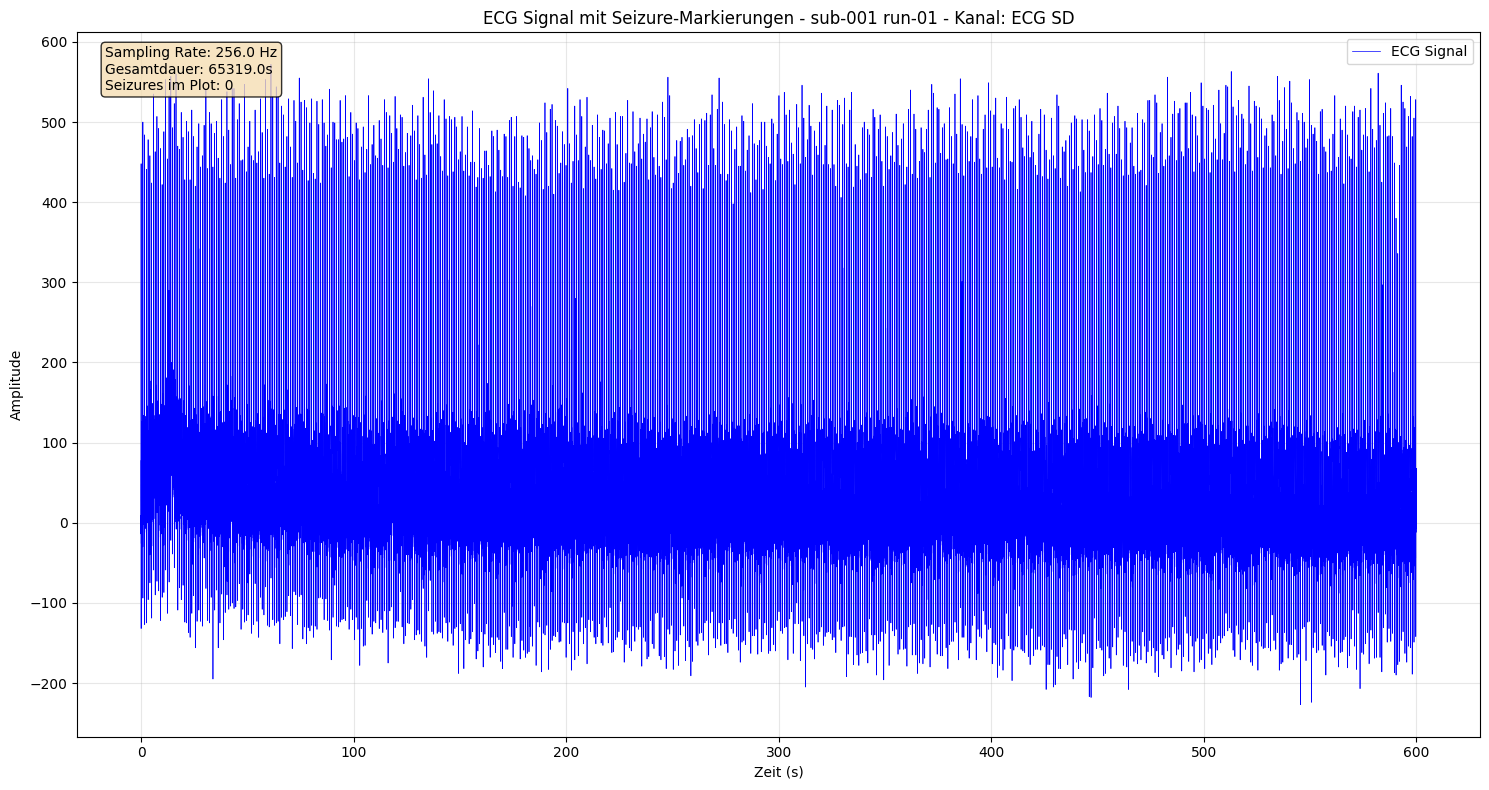

ECG-Daten geladen:
  - Kanäle: ['ECG SD']
  - Sampling Rates: [np.float64(256.0)] Hz
  - Datenpunkte: 153600
  - Dauer: 65319.0 Sekunden


In [16]:
# Finde Patienten mit Seizures
seizure_patients = find_patients_with_seizures(dataset_path, max_patients=10)

if seizure_patients:
    print(f"\nGefunden: {len(seizure_patients)} Aufnahmen mit Seizures")
    print("=" * 50)
    
    # Plotte den ersten Patienten mit Seizures
    patient_id, run_id, seizure_count = seizure_patients[0]
    print(f"\nPlotte {patient_id} {run_id} mit {seizure_count} Seizure(s):")
    
    # Längere Zeitspanne um Seizures zu zeigen
    data, annotations = plot_patient_ecg(dataset_path, patient_id=patient_id, duration_minutes=10)
    
else:
    print("Keine Patienten mit Seizure-Annotationen in den ersten 10 Patienten gefunden.")
    print("Versuche mit Standard-Patient sub-001...")
    data, annotations = plot_patient_ecg(dataset_path, patient_id='sub-001', duration_minutes=5)

## Detailed Seizure Analysis

Let's create a function to plot a focused view around seizure events.

\nDetaillierter Blick auf erste Seizure von sub-006 run-01:


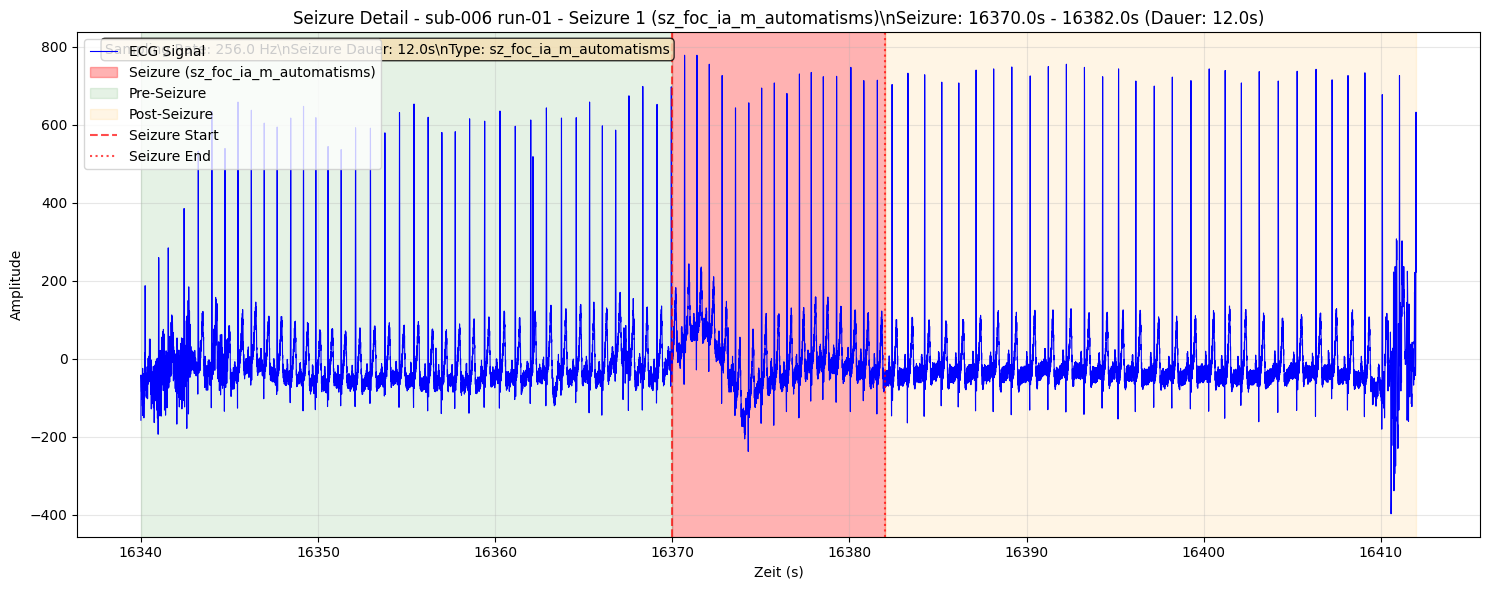

Seizure Detail Plot:
  - Patient: sub-006 run-01
  - Seizure 1: 16370.0s - 16382.0s
  - Dauer: 12.0s
  - Type: sz_foc_ia_m_automatisms


In [28]:
def plot_seizure_detail(data_path, patient_id, run_id, seizure_index=0, pre_seizure_sec=30, post_seizure_sec=30):
    """
    Plottet einen detaillierten Blick auf eine spezifische Seizure
    
    Args:
        data_path (str): Pfad zum Dataset
        patient_id (str): Patient ID
        run_id (str): Run ID
        seizure_index (int): Index der Seizure (0 = erste)
        pre_seizure_sec (int): Sekunden vor der Seizure
        post_seizure_sec (int): Sekunden nach der Seizure
    """
    
    # Lade Daten
    recording = [patient_id, run_id]
    data = Data.loadData(data_path, recording, modalities=['ecg'])
    annotations = Annotation.loadAnnotation(data_path, recording)
    
    if not annotations.events or seizure_index >= len(annotations.events):
        print(f"Seizure {seizure_index} nicht gefunden!")
        return
    
    seizure_start, seizure_end = annotations.events[seizure_index]
    seizure_type = annotations.types[seizure_index] if seizure_index < len(annotations.types) else 'unknown'
    
    # ECG-Signal vorbereiten
    ecg_signal = data.data[0]
    fs = data.fs[0]
    
    # Zeitfenster definieren
    plot_start_time = max(0, seizure_start - pre_seizure_sec)
    plot_end_time = min(len(ecg_signal)/fs, seizure_end + post_seizure_sec)
    
    # Sample-Indices berechnen
    start_idx = int(plot_start_time * fs)
    end_idx = int(plot_end_time * fs)
    
    # Signal und Zeit extrahieren
    plot_signal = ecg_signal[start_idx:end_idx]
    plot_time = np.linspace(plot_start_time, plot_end_time, len(plot_signal))
    
    # Plot erstellen
    plt.figure(figsize=(15, 6))
    plt.plot(plot_time, plot_signal, 'b-', linewidth=0.8, label='ECG Signal')
    
    # Seizure-Bereich markieren
    plt.axvspan(seizure_start, seizure_end, alpha=0.3, color='red', label=f'Seizure ({seizure_type})')
    
    # Pre- und Post-Seizure Bereiche markieren
    plt.axvspan(plot_start_time, seizure_start, alpha=0.1, color='green', label='Pre-Seizure')
    plt.axvspan(seizure_end, plot_end_time, alpha=0.1, color='orange', label='Post-Seizure')
    
    # Vertikale Linien für Seizure-Grenzen
    plt.axvline(seizure_start, color='red', linestyle='--', alpha=0.7, label='Seizure Start')
    plt.axvline(seizure_end, color='red', linestyle=':', alpha=0.7, label='Seizure End')
    
    plt.xlabel('Zeit (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Seizure Detail - {patient_id} {run_id} - Seizure {seizure_index+1} ({seizure_type})\\n'
              f'Seizure: {seizure_start:.1f}s - {seizure_end:.1f}s (Dauer: {seizure_end-seizure_start:.1f}s)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Info-Box
    info_text = f'Sampling Rate: {fs} Hz\\nSeizure Dauer: {seizure_end-seizure_start:.1f}s\\nType: {seizure_type}'
    plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Seizure Detail Plot:")
    print(f"  - Patient: {patient_id} {run_id}")
    print(f"  - Seizure {seizure_index+1}: {seizure_start:.1f}s - {seizure_end:.1f}s")
    print(f"  - Dauer: {seizure_end-seizure_start:.1f}s")
    print(f"  - Type: {seizure_type}")

# Beispiel-Verwendung für Patienten mit Seizures
if seizure_patients:
    patient_id, run_id, seizure_count = seizure_patients[15]
    print(f"\\nDetaillierter Blick auf erste Seizure von {patient_id} {run_id}:")
    plot_seizure_detail(dataset_path, patient_id, run_id, seizure_index=0)